<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/census_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import all of the necessary libraries in
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on

def s_parity(test_data, predictors, prediction_df, sensitive_attr, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: outcome
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]==0]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]==1]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 0)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 1)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [3]:
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the LR model
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        clf = DecisionTreeClassifier(criterion = 'entropy', random_state=658,max_depth = 3, min_samples_leaf=5)
        #clf = LogisticRegression()
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [4]:
#Initialize the data from the adult.test dataset
columns= ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
          'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', 'label']

census_data = pd.read_csv('adult.test', header=None, index_col=None, sep=',', names=columns)

In [5]:
#Replace values in the dataframe
#>50k is 1 and <=50k is 0

type_dict = {' <=50K.': 0,
             ' >50K.' : 1}
census_data['label'] = census_data['label'].apply(lambda x: type_dict[x])
census_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,0
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [6]:
#Encode the data with dummy values
#This is for the categorical columns
categorical_columns = ['workclass','education','marital-status','occupation',
                       'relationship','race','sex','native-country']
encoded_census_data = pd.get_dummies(census_data,columns=categorical_columns,drop_first=True)
print(encoded_census_data.columns.to_list())

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'label', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupat

In [7]:
#Set the target variable and the predictor variable for the decision tree
target_var = 'label'
predictors=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov',
            'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc',
            'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 11th',
            'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th',
            'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad',
            'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college',
            'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent',
            'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical',
            'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
            'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service',
            'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales',
            'occupation_ Tech-support', 'occupation_ Transport-moving', 'relationship_ Not-in-family', 'relationship_ Other-relative',
            'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ Asian-Pac-Islander', 'race_ Black',
            'race_ Other', 'race_ White', 'sex_ Male', 'native-country_ Cambodia', 'native-country_ Canada', 'native-country_ China',
            'native-country_ Columbia', 'native-country_ Cuba', 'native-country_ Dominican-Republic', 'native-country_ Ecuador',
            'native-country_ El-Salvador', 'native-country_ England', 'native-country_ France', 'native-country_ Germany',
            'native-country_ Greece', 'native-country_ Guatemala', 'native-country_ Haiti', 'native-country_ Honduras',
            'native-country_ Hong', 'native-country_ Hungary', 'native-country_ India', 'native-country_ Iran',
            'native-country_ Ireland', 'native-country_ Italy', 'native-country_ Jamaica', 'native-country_ Japan',
            'native-country_ Laos', 'native-country_ Mexico', 'native-country_ Nicaragua', 'native-country_ Outlying-US(Guam-USVI-etc)',
            'native-country_ Peru', 'native-country_ Philippines', 'native-country_ Poland', 'native-country_ Portugal',
            'native-country_ Puerto-Rico', 'native-country_ Scotland', 'native-country_ South', 'native-country_ Taiwan',
            'native-country_ Thailand', 'native-country_ Trinadad&Tobago', 'native-country_ United-States', 'native-country_ Vietnam',
            'native-country_ Yugoslavia']




In [8]:
#Encode x and y to take the proper columns
x = encoded_census_data[predictors].values
y = encoded_census_data[target_var].values

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [10]:
#Run the DT classifier
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 658, max_depth = 3, min_samples_leaf=5)
log = clf.fit(x_train,y_train)
prediction = log.predict(x_test)

In [11]:
#Print out the accuracy of the Decision Tree
acc = accuracy_score(y_test,prediction)*100
print(f'Accuracy is {acc:.5f}')

Accuracy is 83.75806


In [12]:
#Break the test dataframe into different groups
#Unprotected group is women
#Complement group is men
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['outcome'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['sex_ Male']==0]))
total_priv = (len(concat_df[concat_df['sex_ Male']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['outcome'] == 1) & (concat_df['sex_ Male']==0)])
total_credit_priv = len(concat_df[(concat_df['outcome'] == 1) & (concat_df['sex_ Male']==1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.15316


In [13]:
#Combine x_train and y_train
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['label'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [14]:
#File to write the information to
#When flipping the label make sure convert the flip before into its original value
#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate shenanigans
#Implement label flipping and recalculate
list_parity = []
list_num = []
list_flip = []

for index, row in train_full_df.iterrows():
    if row['label'] == 1:
        train_full_df.at[index, 'label'] = 0

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'outcome')

        list_flip.append(index)
        list_num.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'sex_ Male', 'outcome')
        list_parity.append(parity)

        #train_full_df.at[index,'label'] = 1

    elif row['label'] == 0:
        train_full_df.at[index, 'label'] = 1

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'outcome')
        list_flip.append(index)
        list_num.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'sex_ Male', 'outcome')
        list_parity.append(parity)

        #train_full_df.at[index,'label'] = 0

In [15]:
parity_difference = []
large_influence = []
large_influence_negative = []
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)

#After taking the difference I rank these values and don't need to take the absolute values and rank those

#Rows are considered to be high influence if they fall in between .03, -.03
for index, item in enumerate(parity_difference):
    if item <= .16 and item >= -.16:
        large_influence.append(item)
        #print(f"Index: {index}, Item: {item}")
        li_row.append(index+1)

In [37]:
#Ranking the values that have been appended to the large_influence list
zip_lists = list(zip(large_influence, li_row))

#Sort the list of tuples based on the absolute value of the values
sorted_pairs = sorted(zip_lists, key=lambda pair: pair[0], reverse=True)

#Separate the sorted values and indices back into separate lists
sorted_values, sorted_indices = zip(*sorted_pairs)

In [42]:
#Get the top values
top_ranked_noABS = sorted_values[:500]
top_ranked_noABS_index = sorted_indices[:500]

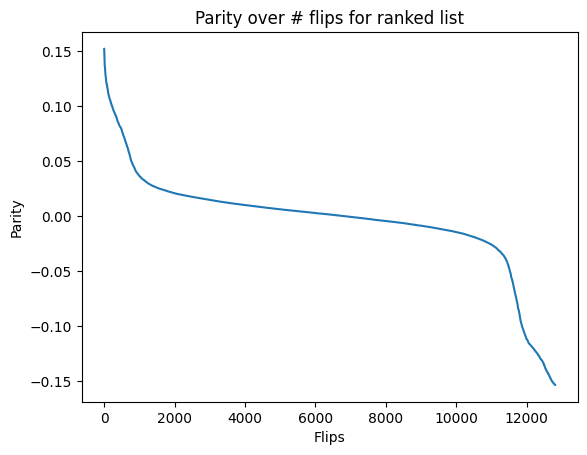

In [43]:
#Plot of the information in the order of the flips of parity
x=range(len(sorted_values))

#Plot the data
plt.plot(x,sorted_values)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

In [44]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'label'
budget = 500

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
for iter in range(budget):
    random_row = random.choice(train_full_df.index)
    if train_full_df.at[random_row,col_name] == 1:
        train_full_df.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var,'outcome')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'sex_ Male','outcome')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df.at[random_row,col_name] == 0:
        train_full_df.at[random_row,col_name] = 1

        accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var,'outcome')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'sex_ Male', 'outcome')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 0

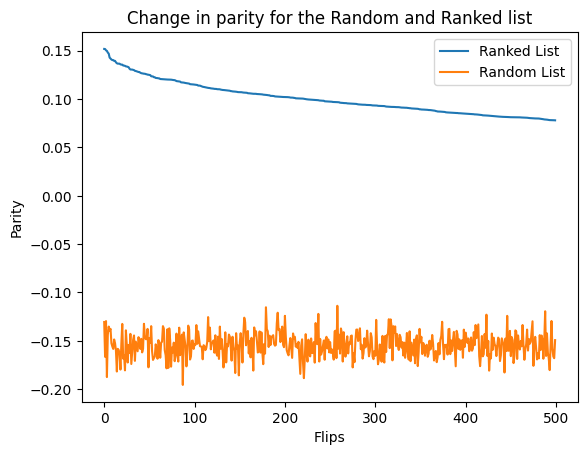

In [45]:
#I don't sort by absolute value again rather I just take the values as they are
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(top_ranked_noABS))
plt.plot(x,top_ranked_noABS,label='Ranked List')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()